In [1]:
#https://www.youtube.com/watch?v=OhY5ZaILRpg
library(tidytuesdayR)
library(tidyverse)

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.0     v purrr   0.3.4
v tibble  3.0.1     v dplyr   0.8.5
v tidyr   1.1.0     v stringr 1.4.0
v readr   1.3.1     v forcats 0.5.0

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



In [2]:
tuesdata <- tidytuesdayR::tt_load(2020, week = 18)

--- Downloading #TidyTuesday Information for 2020-04-28 ----

--- Identified 4 files available for download ----

--- Downloading files ---

Warning message:
"71078 parsing failures.
 row              col           expected actual                                                                         file
6862 potential_gross  1/0/T/F/TRUE/FALSE 383843 'C:\Users\fedeZzZ\AppData\Local\Temp\Rtmp4KNBKx\file2a1474a4230f.csv'
6862 top_ticket_price 1/0/T/F/TRUE/FALSE 50     'C:\Users\fedeZzZ\AppData\Local\Temp\Rtmp4KNBKx\file2a1474a4230f.csv'
6885 potential_gross  1/0/T/F/TRUE/FALSE 383843 'C:\Users\fedeZzZ\AppData\Local\Temp\Rtmp4KNBKx\file2a1474a4230f.csv'
6885 top_ticket_price 1/0/T/F/TRUE/FALSE 50     'C:\Users\fedeZzZ\AppData\Local\Temp\Rtmp4KNBKx\file2a1474a4230f.csv'
6909 potential_gross  1/0/T/F/TRUE/FALSE 383843 'C:\Users\fedeZzZ\AppData\Local\Temp\Rtmp4KNBKx\file2a1474a4230f.csv'
.... ................ .................. ...... ......................................................

In [3]:
grosses <- tuesdata$grosses

In [4]:
names(grosses)

[1] "week_ending"          "week_number"          "weekly_gross_overall"
 [4] "show"                 "theatre"              "weekly_gross"        
 [7] "potential_gross"      "avg_ticket_price"     "top_ticket_price"    
[10] "seats_sold"           "seats_in_theatre"     "pct_capacity"        
[13] "performances"         "previews"

### Averages using tidymetrics

to do rolling windows use windows argument.

In [5]:
library(tidymetrics)


Attaching package: 'tidymetrics'


The following object is masked from 'package:stats':

    filter




In [6]:
lion_king_processed <- 
    grosses %>% 
        filter(show == "The Lion King") %>% 
        rename(date = week_ending) %>% 
        cross_by_periods(periods = c("month", "quarter", "year"), 
                         windows = c(28)) %>% 
        summarise(usd_gross = sum(weekly_gross), 
                  avg_ticket_price = mean(avg_ticket_price), 
                  mean_capacity = mean(pct_capacity)) 

Warning message:
"unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(offset))`, with `mutate()` if needed"


In [7]:
lion_king_processed %>% head()

period,date,usd_gross,avg_ticket_price,mean_capacity
<chr>,<date>,<dbl>,<dbl>,<dbl>
month,1997-10-01,1355041,58.6900,0.882050
month,1997-11-01,3636271,56.6660,0.919180
month,1997-12-01,3262879,57.8025,1.010825
month,1998-01-01,3250823,57.8675,1.005925
month,1998-02-01,3202440,57.1250,1.003925
month,1998-03-01,4007274,56.9220,1.008620


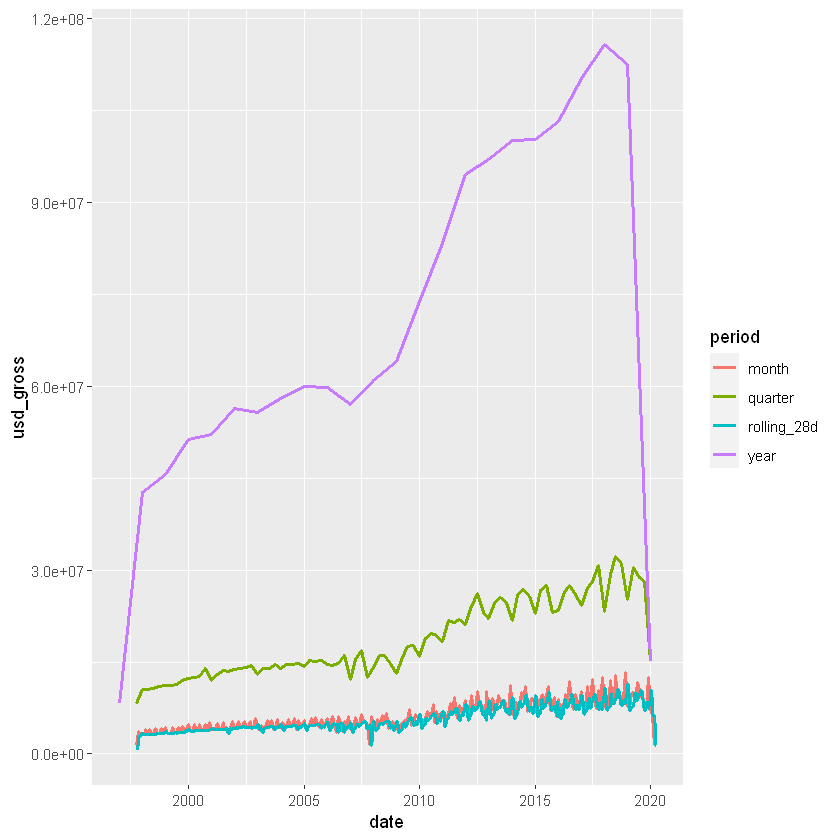

In [8]:
lion_king_processed %>% 
    ggplot(aes(date, usd_gross, color = period)) +
        geom_line(size = 1.1)

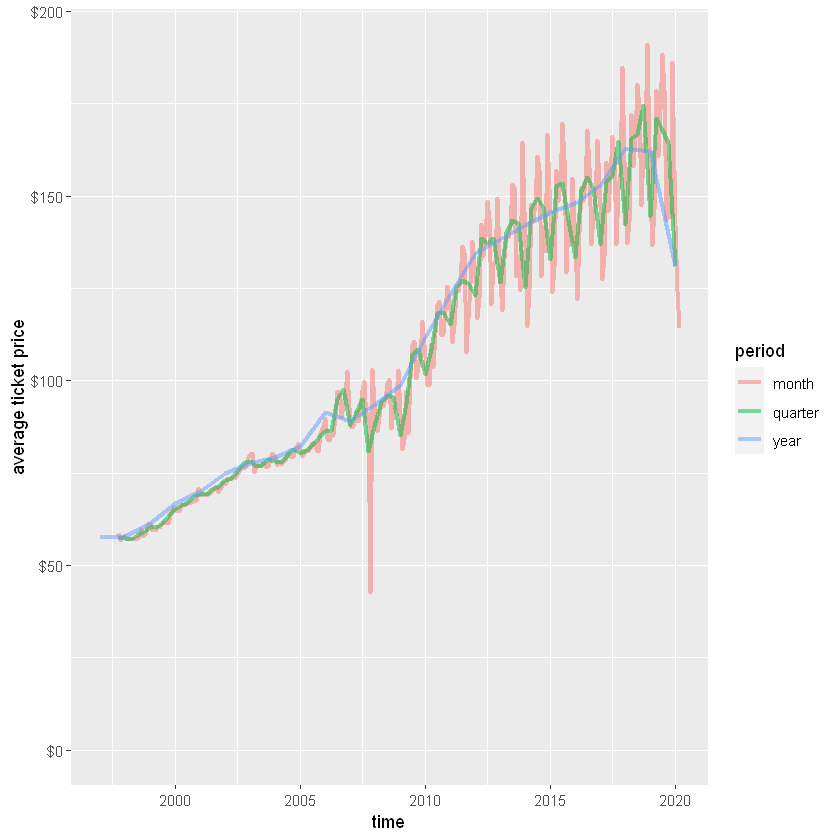

In [9]:
lion_king_processed %>% 
    filter(period != "rolling_28d") %>% 
    ggplot(aes(date, avg_ticket_price, color = period)) +
        geom_line(size = 1.2, alpha = 0.5) +
        scale_y_continuous(labels = scales::dollar_format()) +
        expand_limits(y = 0) +
        labs(x = "time", 
             y = "average ticket price", 
             color = "period")

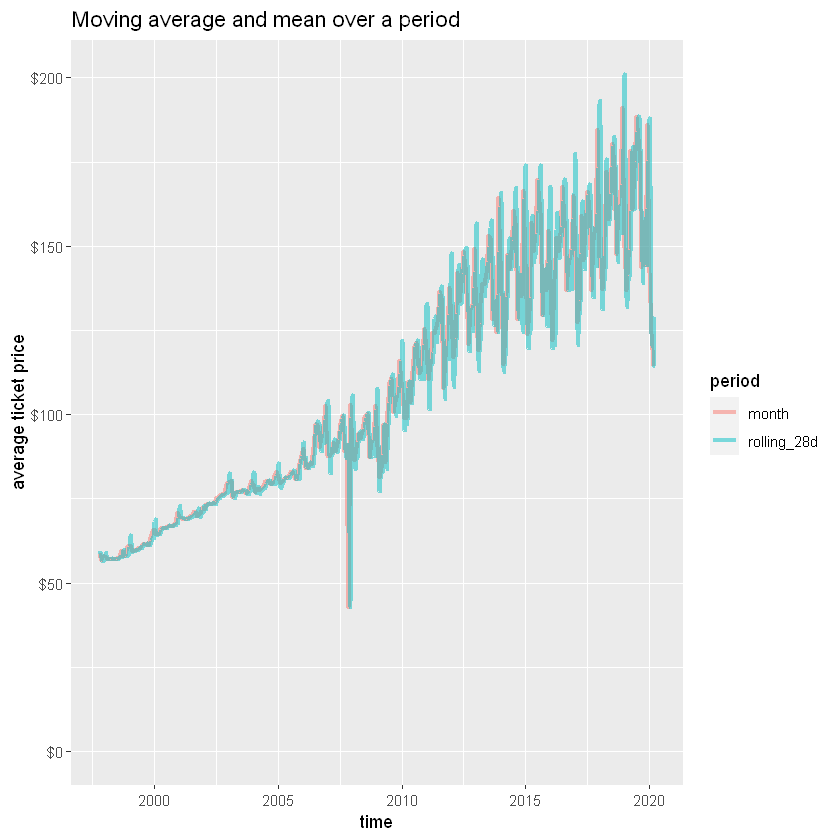

In [10]:
lion_king_processed %>% 
    filter(period %in% c("month", "rolling_28d")) %>% 
    ggplot(aes(date, avg_ticket_price, color = period)) +
        geom_line(size = 1.2, alpha = 0.5) +
        scale_y_continuous(labels = scales::dollar_format()) +
        expand_limits(y = 0) +
        labs(x = "time", 
             y = "average ticket price", 
             color = "period", 
             title = "Moving average and mean over a period")

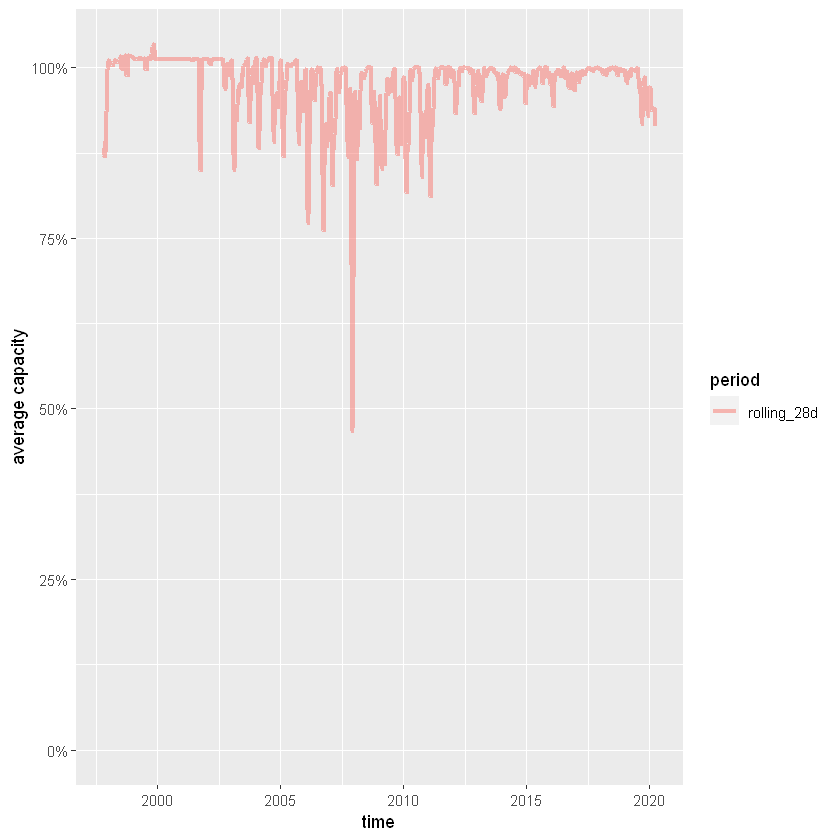

In [11]:
lion_king_processed %>% 
    filter(period == "rolling_28d") %>% 
    ggplot(aes(date, mean_capacity, color = period)) +
        geom_line(size = 1.2, alpha = 0.5) +
        scale_y_continuous(labels = scales::percent_format()) +
        expand_limits(y = 0) +
        labs(x = "time", 
             y = "average capacity", 
             color = "period")

## Dashboards

In [12]:
# Harry Potter musical?
grosses %>%
    filter(str_detect(show, "Potter"))  %>% 
    distinct(show)

show
<chr>
"Harry Potter and the Cursed Child, Parts One and Two"


In [13]:
shows_summarized <- 
    grosses %>% 
        filter(show %in% 
               c("Hamilton", 
                 "The Lion King", 
                 "Rent", 
                 "Wicked", 
                 "Harry Potter and the Cursed Child, Parts One and Two", 
                 "The Book of Mormon")) %>% 
        mutate(show = str_remove(show, "\\, Parts.*")) %>% 
        rename(date = week_ending) %>% 
        cross_by_dimensions(show) %>% # same as group_by??? No, has an all group/level
        cross_by_periods(periods = c("month", "quarter", "year"), 
                         windows = c(28)) %>% 
        summarise(usd_gross = sum(weekly_gross), 
                  avg_ticket_price = mean(avg_ticket_price), 
                  mean_capacity = mean(pct_capacity))  %>% 
        ungroup()

Warning message:
"unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(offset))`, with `mutate()` if needed"


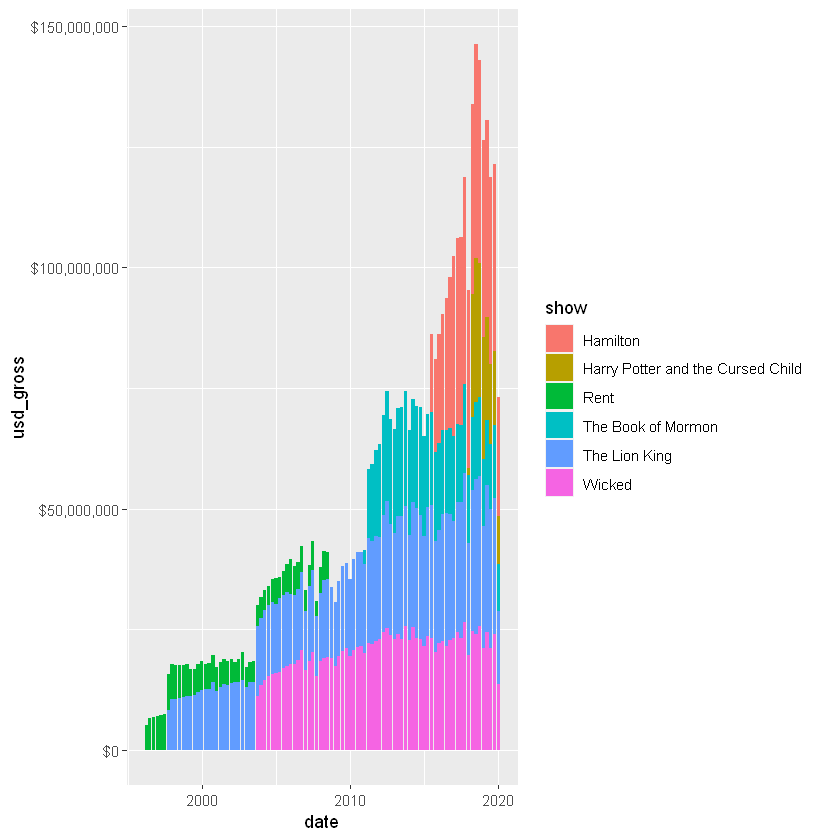

In [14]:
shows_summarized %>% 
    filter(period == "quarter", 
           show != "All") %>% 
    ggplot(aes(date, usd_gross, fill = show)) +
        geom_col() +
        scale_y_continuous(labels = scales::dollar_format())

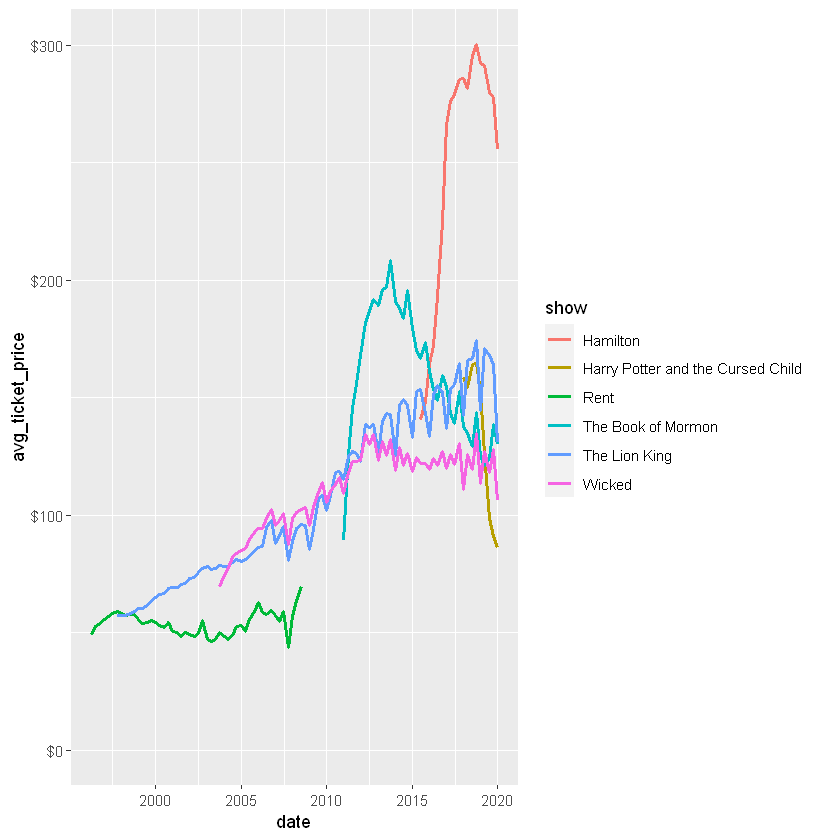

In [15]:
shows_summarized %>% 
    filter(period == "quarter", 
           show != "All") %>% 
    ggplot(aes(date, avg_ticket_price, color = show)) +
        geom_line(size = 1) +
        scale_y_continuous(labels = scales::dollar_format()) + 
        expand_limits(y = 0)

In [16]:
shows_summarized %>% head()

show,period,date,usd_gross,avg_ticket_price,mean_capacity
<chr>,<chr>,<date>,<dbl>,<dbl>,<dbl>
All,month,1996-04-01,894317,48.2700,0.98765
All,month,1996-05-01,1798022,47.0575,1.01790
All,month,1996-06-01,2439314,51.0320,1.01880
All,month,1996-07-01,1989411,52.0250,1.01880
All,month,1996-08-01,2019736,52.8175,1.01880
All,month,1996-09-01,2520455,52.7300,1.01880


In [17]:
library(shinymetrics)

In [18]:
shows_metrics <- create_metrics(shows_summarized)

ERROR: Error: RStudio not running
